In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
df = pd.read_csv('../train.csv')
df.head(2)

id                                         annotation  width  \
0  0030fd0e6378  118145 6 118849 7 119553 8 120257 8 120961 9 1...    704   
1  0030fd0e6378  189036 1 189739 3 190441 6 191144 7 191848 8 1...    704   

   height cell_type plate_time sample_date  \
0     520    shsy5y  11h30m00s  2019-06-16   
1     520    shsy5y  11h30m00s  2019-06-16   

                            sample_id elapsed_timedelta  
0  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
1  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00

### Function that decodes rle (for this comp) to a binary mask

In [24]:
## Based on: https://www.kaggle.com/eigrad/convert-rle-to-bounding-box-x0-y0-x1-y1
def rle2mask(rle, img_w, img_h):
    
    ## transforming the string into an array of shape (2, N)
    array = np.fromiter(rle.split(), dtype = np.uint)
    array = array.reshape((-1,2)).T
    array[0] = array[0] - 1
    
    ## decompressing the rle encoding (ie, turning [3, 1, 10, 2] into [3, 4, 10, 11, 12])
    # for faster mask construction
    starts, lenghts = array
    mask_decompressed = np.concatenate([np.arange(s, s + l, dtype = np.uint) for s, l in zip(starts, lenghts)])

    ## Building the binary mask
    msk_img = np.zeros(img_w * img_h, dtype = np.uint8)
    msk_img[mask_decompressed] = 1
    msk_img = msk_img.reshape((img_h, img_w))
    msk_img = np.asfortranarray(msk_img) ## This is important so pycocotools can handle this object
    
    return msk_img

simple test

In [25]:
# rle = df.loc[1, 'annotation']
# print(rle)
# plt.imshow(rle2mask(rle, 704, 520));

### Fix overlap

In [26]:
import tensorflow as tf

In [27]:
def check_overlap(msk):
    msk = msk.astype(np.bool).astype(np.uint8)
    return np.any(np.sum(msk, axis=-1)>1)

def fix_overlap(msk):
    """
    Args:
        mask: multi-channel mask, each channel is an instance of cell, shape:(520,704,None)
    Returns:
        multi-channel mask with non-overlapping values, shape:(520,704,None)
    """
    msk = np.array(msk)
    msk = np.pad(msk, [[0,0],[0,0],[1,0]])
    ins_len = msk.shape[-1]
    msk = np.argmax(msk,axis=-1)
    msk = tf.keras.utils.to_categorical(msk, num_classes=ins_len)
    msk = msk[...,1:]
    msk = msk[...,np.any(msk, axis=(0,1))]
    return msk

In [28]:
# mask = np.zeros((520, 704, 5))

# # Before Fix
# plt.figure(figsize=(5*5, 5))
# for idx in range(5):
#     mask[idx*50+50:(idx*50+200), idx*50+50:(idx*50+200), idx] = idx+1 # probabilistic mask isntead of binary mask
#     plt.subplot(1, 5, idx+1)
#     plt.imshow(mask[...,idx]);
#     plt.axis('OFF')
#     plt.title(f'instance: {idx}', fontsize=15)
# plt.tight_layout()
# plt.show()

# ## After Fix
# plt.figure(figsize=(5*5, 5))
# fixed_mask = fix_overlap(mask)
# for idx in range(5):
#     plt.subplot(1, 5, idx+1)
#     plt.imshow(fixed_mask[...,idx]);
#     plt.axis('OFF')
#     plt.title(f'instance: {idx}', fontsize=15)
# plt.tight_layout()
# plt.show()

### Build .json file

In [29]:
import pycocotools.coco as coco

In [30]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# def rle2mask(rle, input_shape):
#     width, height = input_shape[:2]
    
#     mask= np.zeros( width*height ).astype(np.uint8)
    
#     array = np.asarray([int(x) for x in rle.split()])
#     starts = array[0::2]
#     lengths = array[1::2]

#     current_position = 0
#     for index, start in enumerate(starts):
#         mask[int(start):int(start+lengths[index])] = 1
#         current_position += lengths[index]   
#     return mask.reshape(height, width).T

In [31]:
def bounding_box(img):
    # return max and min of a mask to draw bounding box
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax

In [32]:
from tqdm.notebook import tqdm
from pycocotools import mask as maskUtils
from joblib import Parallel, delayed

In [33]:
# cat_ids = {name:id+1 for id, name in enumerate(df.cell_type.unique())}

# image_ids = df.id.unique()

# idx = 0

# df_img = df[df['id'] == image_ids[1]]
# df_img['mask'] = df_img['annotation'].apply(lambda x : rle2mask(x, 704, 520))
# masks = list(df_img.loc[:, 'mask'])
# masks = np.stack(masks)
# masks = masks.transpose(1, 2, 0)
# masks = fix_overlap(masks)
# masks = masks.transpose(2, 0, 1)
# annos = []
# row = df_img

# for _id, mask in enumerate(masks):
#     mask=np.asfortranarray(mask, dtype='uint8')
#     c_rle = maskUtils.encode(mask) # Encoding it back to rle (coco format)
#     c_rle['counts'] = c_rle['counts'].decode('utf-8') # converting from binary to utf-8
#     area = maskUtils.area(c_rle).item() # calculating the area
#     bbox = maskUtils.toBbox(c_rle).astype(int).tolist() # calculating the bboxes
#     annotation = {
#         'segmentation': c_rle,
#         'bbox': bbox,
#         'area': area,
#         'image_id':df_img.loc[_id, 'id'], 
#         'category_id':cat_ids[df_img.loc[_id, 'cell_type']], 
#         'iscrowd':0, 
#         'id':idx
#     }
#     annos.append(annotation)
#     idx += 1

In [34]:
# def annotate(idx, row, cat_ids):
#         mask = rle2mask(row['annotation'], row['width'], row['height']) # Binary mask
#         c_rle = maskUtils.encode(mask) # Encoding it back to rle (coco format)
#         c_rle['counts'] = c_rle['counts'].decode('utf-8') # converting from binary to utf-8
#         area = maskUtils.area(c_rle).item() # calculating the area
#         bbox = maskUtils.toBbox(c_rle).astype(int).tolist() # calculating the bboxes
#         annotation = {
#             'segmentation': c_rle,
#             'bbox': bbox,
#             'area': area,
#             'image_id':row['id'], 
#             'category_id':cat_ids[row['cell_type']], 
#             'iscrowd':0, 
#             'id':idx
#         }
#         return annotation

def annotate(img_id, idx, cat_ids, df):
    df_img = df[df['id'] == img_id]
    df_img['mask'] = df_img['annotation'].apply(lambda x : rle2mask(x, 704, 520))
    masks = list(df_img.loc[:, 'mask'])
    masks = np.stack(masks)
    masks = masks.transpose(1, 2, 0)
    masks = fix_overlap(masks)
    masks = masks.transpose(2, 0, 1)
    annos = []

    for _id, mask in enumerate(masks):
        mask=np.asfortranarray(mask, dtype='uint8')
        c_rle = maskUtils.encode(mask) # Encoding it back to rle (coco format)
        c_rle['counts'] = c_rle['counts'].decode('utf-8') # converting from binary to utf-8
        area = maskUtils.area(c_rle).item() # calculating the area
        bbox = maskUtils.toBbox(c_rle).astype(int).tolist() # calculating the bboxes
        annotation = {
            'segmentation': c_rle,
            'bbox': bbox,
            'area': area,
            'image_id':df_img.head(1)['id'].values[0],
            'category_id':cat_ids[df_img.head(1)['cell_type'].values[0]], 
            'iscrowd':0, 
            'id':idx
        }
        annos.append(annotation)
        idx += 1
    return annos, idx
    
# def coco_structure(df, workers = 4):
    
#     ## Building the header
#     cat_ids = {name:id+1 for id, name in enumerate(df.cell_type.unique())}    
#     cats =[{'name':name, 'id':id} for name,id in cat_ids.items()]
#     images = [{'id':id, 'width':row.width, 'height':row.height, 'file_name':f'train/{id}.png'} for id,row in df.groupby('id').agg('first').iterrows()]
    
#     ## Building the annotations
#     annotations = Parallel(n_jobs=workers)(delayed(annotate)(idx, row, cat_ids) for idx, row in tqdm(df.iterrows(), total = len(df)))
        
#     return {'categories':cats, 'images':images, 'annotations':annotations}

def coco_structure(df, workers = 4):
    
    ## Building the header
    cat_ids = {name:id+1 for id, name in enumerate(df.cell_type.unique())}    
    cats =[{'name':name, 'id':id} for name,id in cat_ids.items()]
    images = [{'id':_id, 'width':row.width, 'height':row.height, 'file_name':f'train/{_id}.png'} for _id,row in df.groupby('id').agg('first').iterrows()]
    
    ## Building the annotations
    img_ids = df.id.unique()
#     annotations = Parallel(n_jobs=workers)(delayed(annotate)(idx, row, cat_ids) for img_id in tqdm(img_ids, total = len(img_ids)))
    idx = 0
    annotations = []
    for img_id in tqdm(img_ids, total = len(img_ids)):
        annos, idx = annotate(img_id, idx, cat_ids, df)
        annotations += annos
        
    return {'categories':cats, 'images':images, 'annotations':annotations}

### KFlod

In [35]:
from sklearn.model_selection import StratifiedKFold

In [36]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df['cell_type']), 1):
    df.loc[val_idx, 'fold'] = fold
df['fold'] = df['fold'].astype(np.uint8)

In [37]:
df.to_csv(f'./train_folds.csv', index=False)

In [38]:
# df_train = pd.read_csv('../train.csv')
# df_train_folds = pd.read_csv(f'./train_folds.csv')
# df_train = pd.merge(df_train, df_train_folds, how='inner', on='id')
df_train = pd.read_csv('./train_folds.csv')

In [39]:
df_train

id                                         annotation  width  \
0      0030fd0e6378  118145 6 118849 7 119553 8 120257 8 120961 9 1...    704   
1      0030fd0e6378  189036 1 189739 3 190441 6 191144 7 191848 8 1...    704   
2      0030fd0e6378  173567 3 174270 5 174974 5 175678 6 176382 7 1...    704   
3      0030fd0e6378  196723 4 197427 6 198130 7 198834 8 199538 8 2...    704   
4      0030fd0e6378  167818 3 168522 5 169225 7 169928 8 170632 9 1...    704   
...             ...                                                ...    ...   
73580  ffdb3cc02eef  3610 3 4311 7 5014 9 5717 11 6420 13 7123 15 7...    704   
73581  ffdb3cc02eef  341585 2 342287 5 342988 10 343690 13 344394 1...    704   
73582  ffdb3cc02eef  47788 3 48490 7 49192 11 49896 13 50599 14 513...    704   
73583  ffdb3cc02eef  333290 1 333993 2 334696 4 335399 5 336102 6 3...    704   
73584  ffdb3cc02eef  249775 2 250477 6 251180 8 251882 11 252585 12...    704   

       height cell_type plate_time sample_date  \
0         520    shsy5y  11h30m00s  2019-06-16   
1         520    shsy5y  11h30m00s  2019-06-16   
2         520    shsy5y  11h30m00s  2019-06-16   
3         520    shsy5y  11h30m00s  2019-06-16   
4         520    shsy5y  11h30m00s  2019-06-16   
...       ...       ...        ...         ...   
73580     520      cort  11h59m00s  2020-11-01   
73581     520      cort  11h59m00s  2020-11-01   
73582     520      cort  11h59m00s  2020-11-01   
73583     520      cort  11h59m00s  2020-11-01   
73584     520      cort  11h59m00s  2020-11-01   

                                sample_id elapsed_timedelta  fold  
0      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00     4  
1      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00     3  
2      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00     3  
3      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00     2  
4      shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00     3  
...                                   ...               ...   ...  
73580   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00     4  
73581   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00     4  
73582   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00     5  
73583   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00     5  
73584   cort[debris]_D9-3_Vessel-384_Ph_4   0 days 11:59:00     4  

[73585 rows x 10 columns]

In [40]:
train_folds = []
val_folds = []
for i in range(1, 6):
    train_folds.append(df_train[df_train['fold'] != i])
    val_folds.append(df_train[df_train['fold'] == i])

In [41]:
len(train_folds[0])

58868

In [46]:
import json
import itertools
train_fold_json = [coco_structure(fold) for fold in train_folds[:1]]
val_fold_json = [coco_structure(fold) for fold in val_folds[:1]]

  0%|          | 0/606 [00:00<?, ?it/s]

/home/ruize/miniconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


  0%|          | 0/605 [00:00<?, ?it/s]

In [47]:
# for idx, (train_fold, val_fold) in enumerate(zip(train_fold_json, val_fold_json)):
#     with open(f'./fold_{idx+1}_train.json', 'w+', encoding='utf-8') as f:
#         json.dump(train_fold, f, ensure_ascii=True, indent=4)
#     with open(f'./fold_{idx+1}_val.json', 'w+', encoding='utf-8') as f:
#         json.dump(val_fold, f, ensure_ascii=True, indent=4)

for idx, (train_fold, val_fold) in enumerate(zip(train_fold_json, val_fold_json)):
    with open(f'./fold_{idx+1}_train_overlap.json', 'w+', encoding='utf-8') as f:
        json.dump(train_fold, f, ensure_ascii=True, indent=4)
    with open(f'./fold_{idx+1}_val_overlap.json', 'w+', encoding='utf-8') as f:
        json.dump(val_fold, f, ensure_ascii=True, indent=4)

### Decode the whole df

In [73]:
import json,itertools

In [69]:
root = coco_structure(df)

  0%|          | 0/606 [00:00<?, ?it/s]

/home/ruize/miniconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [74]:
# with open('annotations_train.json', 'w', encoding='utf-8') as f:
#     json.dump(root, f, ensure_ascii=True, indent=4)
with open('annotations_train_overlap.json', 'w', encoding='utf-8') as f:
    json.dump(root, f, ensure_ascii=True, indent=4)

### Check

In [75]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

In [76]:
dataDir=Path('../')
# annFile = Path('./annotations_train.json')
annFile = Path('./annotations_train_overlap.json')
coco = COCO(annFile)
imgIds = coco.getImgIds()

loading annotations into memory...
Done (t=0.94s)
creating index...
index created!


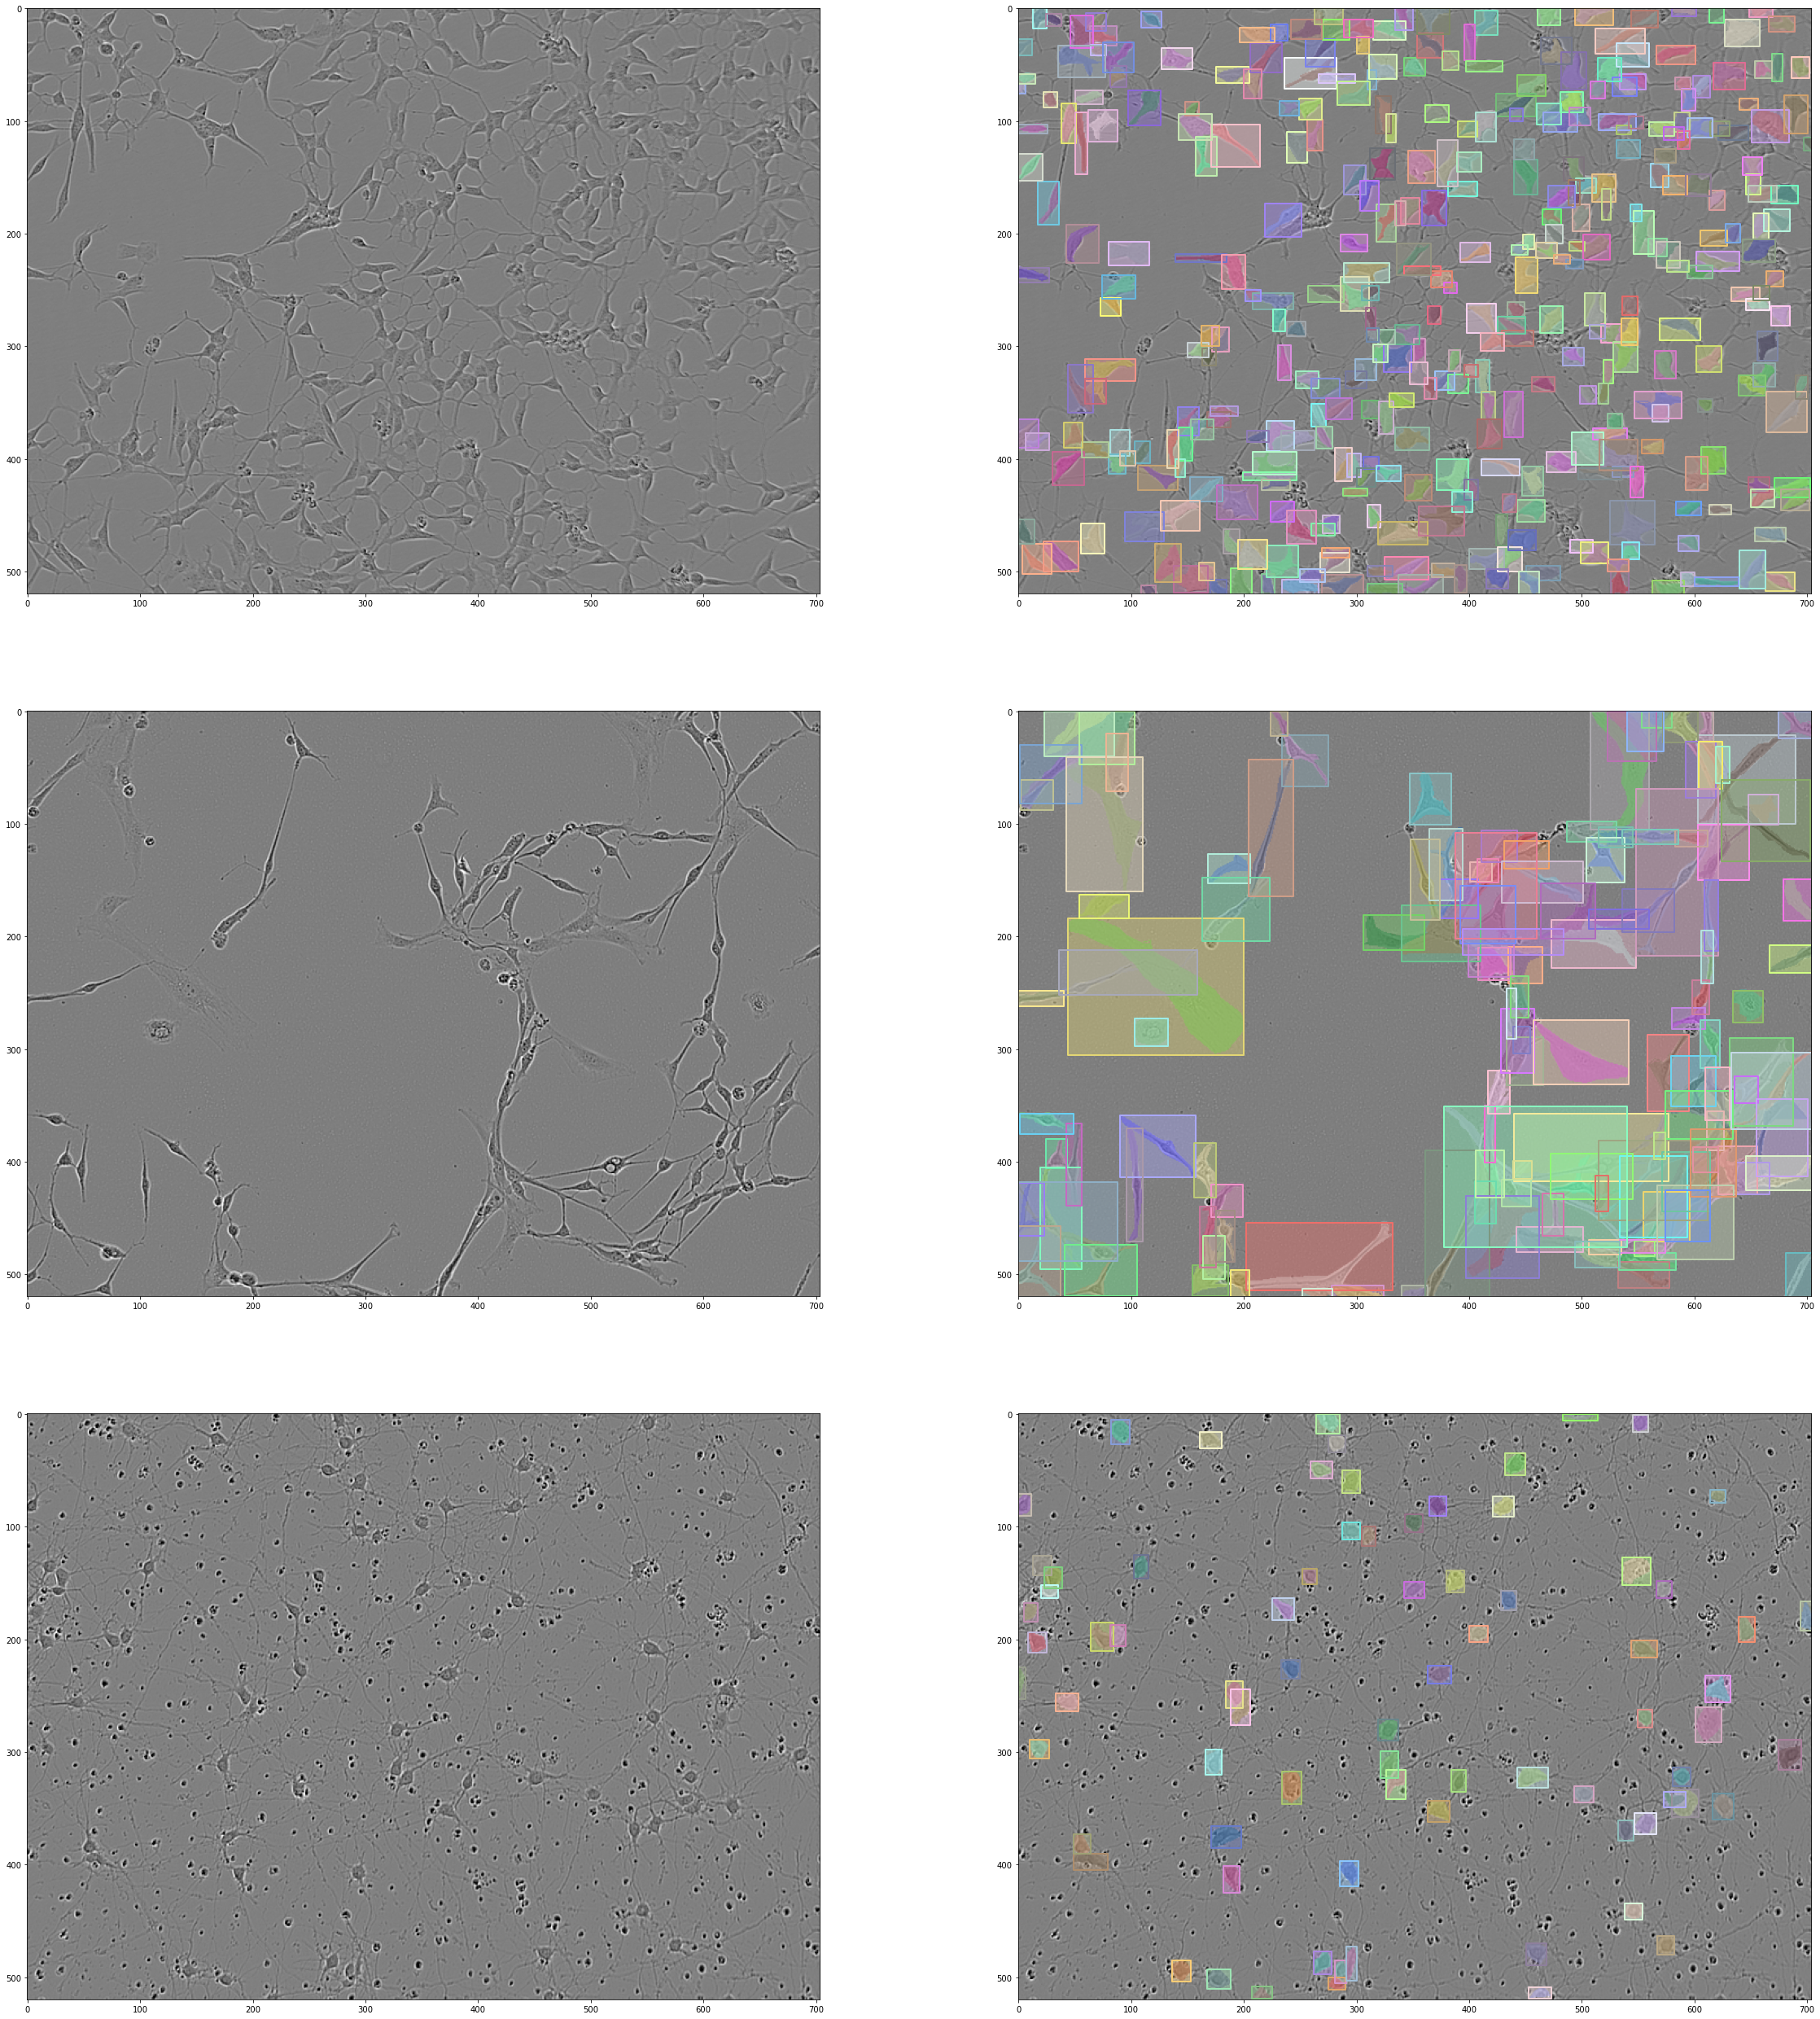

In [77]:
imgs = coco.loadImgs(imgIds[-3:])
_,axs = plt.subplots(len(imgs),2,figsize=(40,15 * len(imgs)))
for img, ax in zip(imgs, axs):
    I = Image.open(dataDir/img['file_name'])
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I, cmap='gray')
    ax[1].imshow(I, cmap='gray')
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)